In [20]:
import uuid
# Run this cell only once and save the code. Use the same id code for each Part.
# Printing random id using uuid1()
print ("The id code is: ",end="")
# unique_id=uuid.uuid1()
unique_id="dd0fd27c-a66a-11ed-9692-8eab187be912"
print (unique_id)

dd0fd27c-a66a-11ed-9692-8eab187be912


In [1]:
#!pip install shap

In [2]:
import numpy as np
import pandas as pd
import cv2
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import skimage as ski

import glob
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import shap
import pprint

In [3]:
import os
for dirname, _, filenames in os.walk('/Users/sje/notebooks/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

/Users/sje/notebooks/data/.DS_Store
/Users/sje/notebooks/data/Arborio/Arborio (14999).jpg
/Users/sje/notebooks/data/Basmati/basmati (1916).jpg
/Users/sje/notebooks/data/Jasmine/Jasmine (11792).jpg


In [4]:
NUM_CLASSES=3

In [5]:
class_folders=["/Users/sje/notebooks/data/Arborio", "/Users/sje/notebooks/data/Basmati","/Users/sje/notebooks/data/Jasmine"]

In [6]:
num_sample_images = 1
image_dict = {}
for i, folder in enumerate(class_folders):
    image_dict[folder.split("/")[-1].split()[0]] = glob.glob(folder + "/*.jpg")[:num_sample_images]

pprint.pprint(image_dict)

{'Arborio': ['/Users/sje/notebooks/data/Arborio/Arborio (14999).jpg'],
 'Basmati': ['/Users/sje/notebooks/data/Basmati/basmati (1916).jpg'],
 'Jasmine': ['/Users/sje/notebooks/data/Jasmine/Jasmine (11792).jpg']}


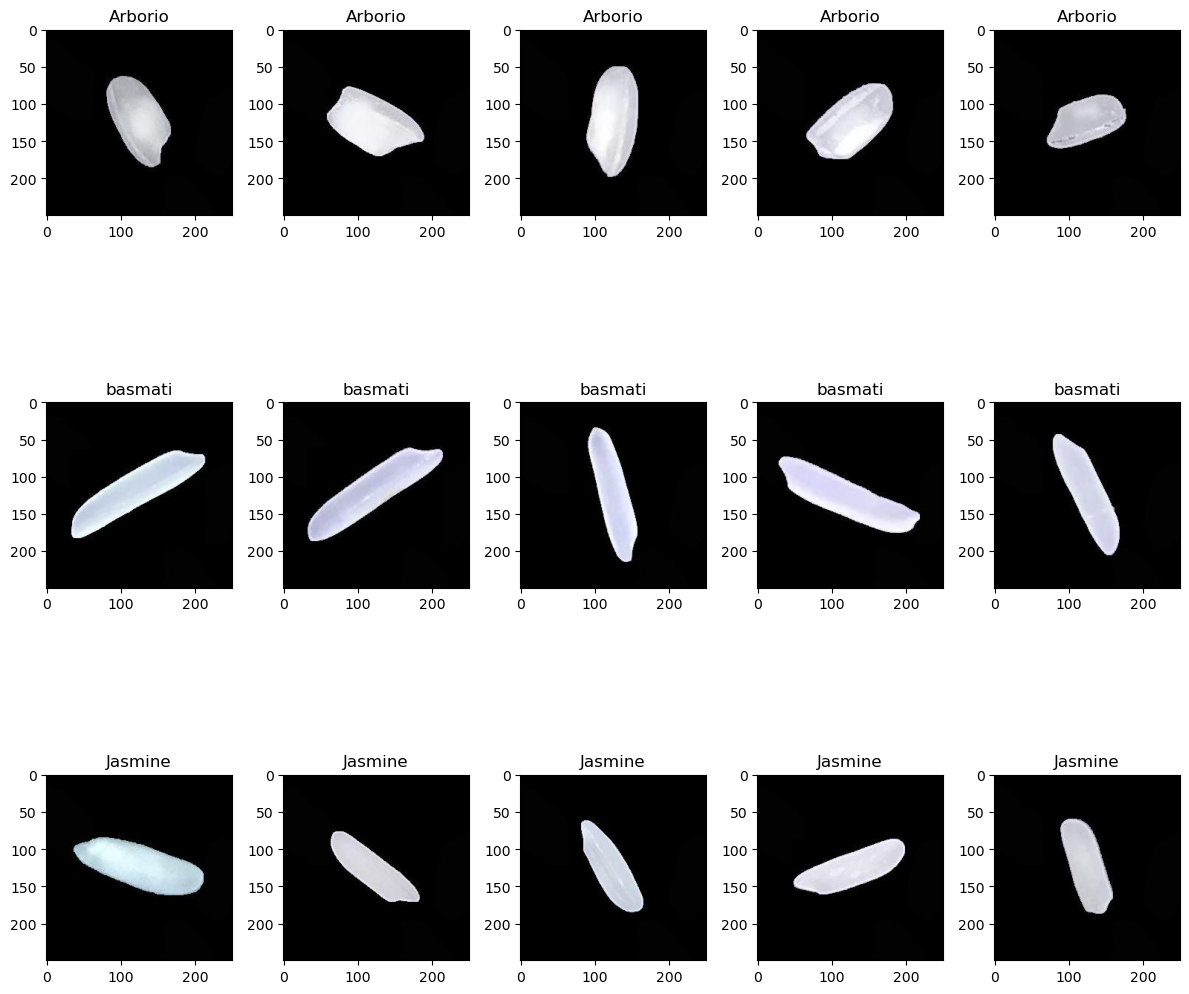

In [7]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(12, 12))
for i, folder in enumerate(class_folders):
    for j, filename in enumerate(glob.glob(folder + "/*.jpg")[:5]):
        img = ski.io.imread(filename)
        axs[i,j].imshow(img)
        axs[i,j].set_title(filename.split("/")[-1].split()[0])
plt.tight_layout();

In [8]:
num_sample_images = 1
image_dict = {}
for i, folder in enumerate(class_folders):
    image_dict[folder.split("/")[-1].split()[0]] = glob.glob(folder + "/*.jpg")[:num_sample_images]

pprint.pprint(image_dict)

{'Arborio': ['/Users/sje/notebooks/data/Arborio/Arborio (14999).jpg'],
 'Basmati': ['/Users/sje/notebooks/data/Basmati/basmati (1916).jpg'],
 'Jasmine': ['/Users/sje/notebooks/data/Jasmine/Jasmine (11792).jpg']}


In [9]:
def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def threshold_image(img, thresh_min=155, thresh_max=255):
    return cv2.threshold(img, thresh_min, thresh_max, cv2.THRESH_BINARY)[1]

def getContours(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return (contours, hierarchy)

def drawContours(image, contours):
    return cv2.drawContours(image, contours, -1, (0, 255, 255), 3)

def calculateImageFeatures(contours, featcols):
    feat_array = np.zeros((1, len(featcols)), np.float32)
    mmnts =  cv2.moments(contours[0], False)
    for i, k in enumerate(sorted(mmnts.keys())):
        feat_array[0, i] = mmnts[k]
    
    area = cv2.contourArea(contours[0], False)
    centroid_x = mmnts['m10']/(mmnts['m00'] + 0.000000000001)
    centroid_y = mmnts['m01']/(mmnts['m00'] + + 0.000000000001)
    arcLength = cv2.arcLength(contours[0], True)
    
    feat_array[0, len(mmnts)] = area
    feat_array[0, len(mmnts)+1] = centroid_x
    feat_array[0, len(mmnts)+2] = centroid_y
    feat_array[0, len(mmnts)+3] = arcLength
    
    return feat_array


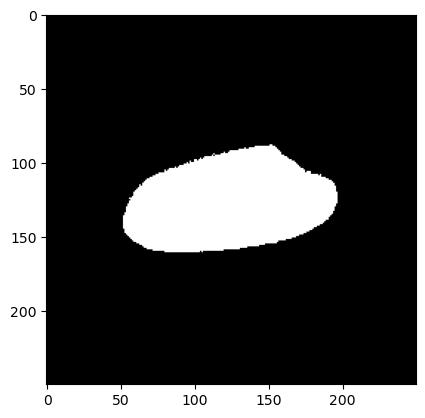

In [10]:
sample_thresh = threshold_image(to_grayscale(cv2.imread("/Users/sje/notebooks/data/Arborio/Arborio (11154).jpg")))
plt.imshow(sample_thresh, cmap='gray');

In [11]:
cnts, h = getContours(sample_thresh)
sample_moments = cv2.moments(cnts[0], False)
#print(sample_moments)

feature_cols = list(sorted(sample_moments.keys())) + ["area", "centroidx", "centroidy", "length"]
pprint.pprint(feature_cols)

sample_features = calculateImageFeatures(cnts, feature_cols)
pprint.pprint(sample_features)

['m00',
 'm01',
 'm02',
 'm03',
 'm10',
 'm11',
 'm12',
 'm20',
 'm21',
 'm30',
 'mu02',
 'mu03',
 'mu11',
 'mu12',
 'mu20',
 'mu21',
 'mu30',
 'nu02',
 'nu03',
 'nu11',
 'nu12',
 'nu20',
 'nu21',
 'nu30',
 'area',
 'centroidx',
 'centroidy',
 'length']
array([[ 7.48850000e+03,  9.52587812e+05,  1.23371768e+08,
         1.62483835e+10,  9.20758000e+05,  1.16120584e+08,
         1.49102336e+10,  1.22957096e+08,  1.54123704e+10,
         1.75157268e+10,  2.19615300e+06, -4.07048550e+06,
        -1.00606225e+06, -3.14257225e+06,  9.74413000e+06,
         1.87995240e+07,  1.17866712e+06,  3.91627289e-02,
        -8.38801323e-04, -1.79405268e-02, -6.47587120e-04,
         1.73761442e-01,  3.87400156e-03,  2.42886890e-04,
         7.48850000e+03,  1.22956268e+02,  1.27206764e+02,
         3.85605133e+02]], dtype=float32)


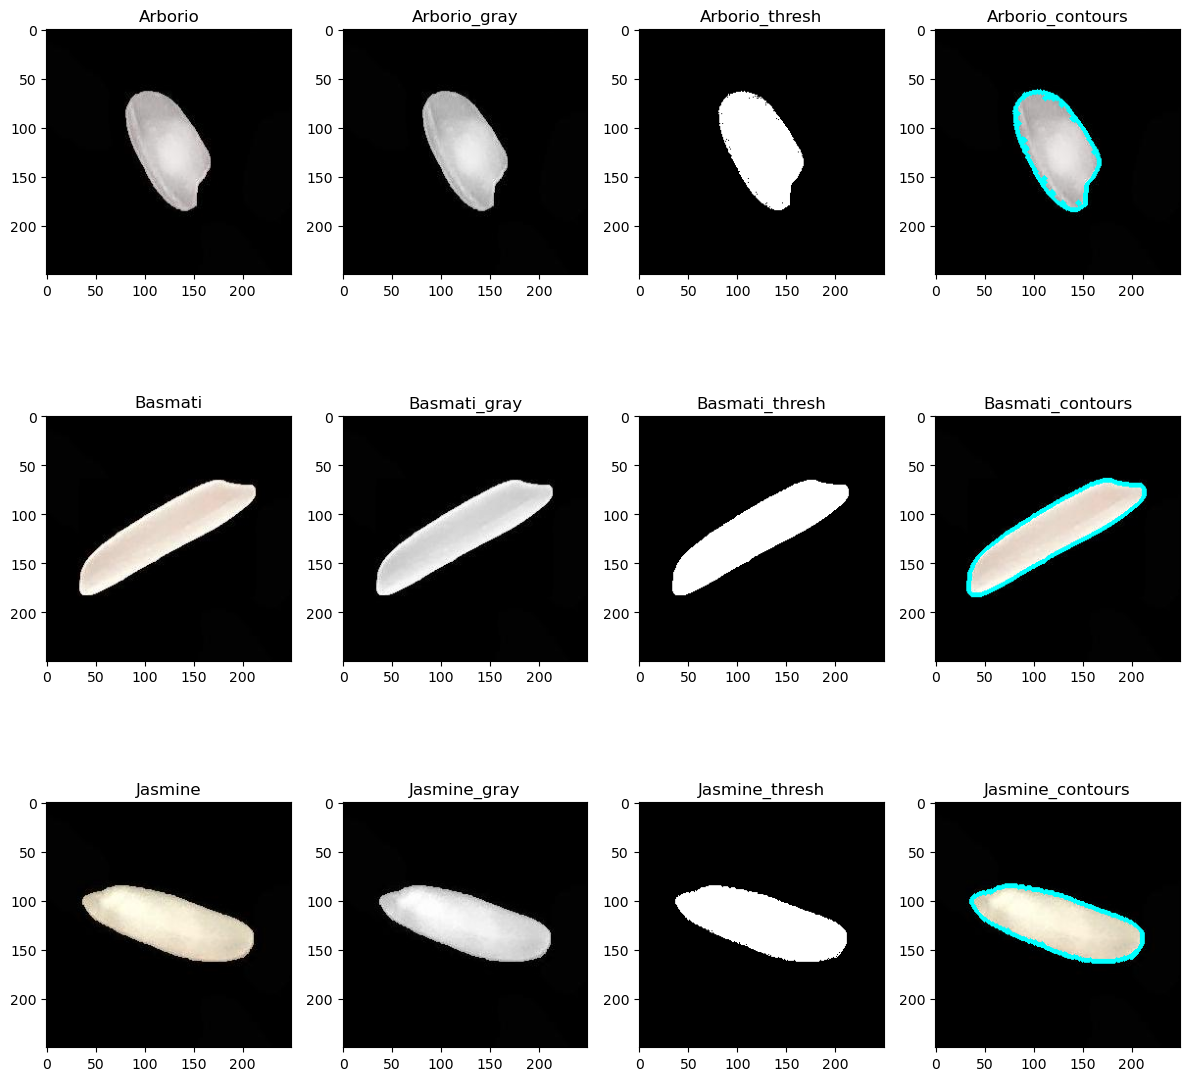

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=num_sample_images*4, figsize=(12, 12))
for i, (k,v) in enumerate(image_dict.items()):
    for j, image_path in enumerate(v):
        img = cv2.imread(image_path)
        gray = to_grayscale(img)
        thresh = threshold_image(gray)
        
        cnts, h = getContours(thresh)
        withConts = drawContours(img.copy(), cnts)
        
        axs[i,j].imshow(img)
        axs[i,j].set_title(k)
        
        axs[i,j+1].imshow(gray, cmap='gray')
        axs[i,j+1].set_title(k + "_gray")
        
        axs[i,j+2].imshow(thresh, cmap='gray')
        axs[i,j+2].set_title(k + "_thresh")
        
        axs[i,j+3].imshow(withConts)
        axs[i,j+3].set_title(k + "_contours")

plt.tight_layout();
